In [1]:
########################################################################
# File       : compare_nucleus_segmentation.ipynb
# Version    : 0.2
# Author     : czsrh
# Date       : 24.11.2020
# Institution : Carl Zeiss Microscopy GmbH
#
# Disclaimer: Just for testing - Use at your own risk.
# Feedback or Improvements are welcome.
########################################################################

In [2]:
import sys
from time import process_time, perf_counter
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imgfileutils as imf
import segmentation_tools as sgt
from aicsimageio import AICSImage, imread
from scipy import ndimage
from skimage import measure, segmentation
from skimage.measure import regionprops
from skimage.color import label2rgb
from MightyMosaic import MightyMosaic
import progressbar
from IPython.display import display, HTML

Trying to find mxnet library ...
ModuleNotFoundError: No module named 'mxnet'
mxnet will not be used.
Trying to find tensorflow library ...
TensorFlow Version :  unknown 1.15.0
Trying to find stardist library ...


Using TensorFlow backend.


In [3]:
# specify the filename of the CZI file
filename = r'A01.czi'

In [4]:
### Define Channel Index containing the nuclei ###
chindex = 0  # channel containing the objects, e.g. the nuclei in DAPI channel


# optional dipslay of "some" results - empty list = no display
show_image = [0]

# toggle additional printed output
verbose = False

# set number of Scenes for testing
# SizeS = 1

In [5]:
# define segmentation method 
# use_method = 'scikit'
# use_method = 'cellpose'
# use_method = 'zentf'
use_method = 'stardist2d'

In [6]:
### Define Segmentation Options for Scikit-image ###

# threshold parameters
filtermethod = 'median'
# filtermethod = None
filtersize = 3
threshold = 'triangle'

# use watershed for splitting - ws or ws_adv
# this can be also used to spit objects from ML-based segmentation
use_ws = True
ws_method = 'ws_adv'
filtersize_ws = 3
min_distance = 5
radius_dilation = 1

In [7]:
# Define Size filter for objects
# Everyzhing smaller or bigger will be filtered out after the segmentation

minsize = 100  # minimum object size [pixel]
maxsize = 5000  # maximum object size [pixel]

In [8]:
# More details about how to use the stardist package
# can be found here: https://pypi.org/project/stardist/

if use_method == 'stardist2d':

    # load pretrained model
    # define StarDist 2D model for nucelus detection
    # 'Versatile (fluorescent nuclei)'
    # 'Versatile (H&E nuclei)'
    # 'DSB 2018 (from StarDist 2D paper)'

    # define and load the stardist model
    sdmodel = sgt.load_stardistmodel(modeltype='Versatile (fluorescent nuclei)')

    # define the model parameters
    print('Setting model parameters.')
    stardist_prob_thresh = 0.5
    stardist_overlap_thresh = 0.3
    stardist_norm = True
    stardist_norm_pmin = 1
    stardist_norm_pmax = 99.8
    stardist_norm_clip = False

Found model '2D_versatile_fluo' with alias 'Versatile (fluorescent nuclei)' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
Setting model parameters.


In [9]:
# More details about how to use the cellpose package
# can be found here: https://pypi.org/project/cellpose/

# load the ML model from cellpose when needed
if use_method == 'cellpose':

    model = sgt.load_cellpose_model(model_type='nuclei')

    # define list of channels for cellpose
    # channels = SizeS * SizeT * SizeZ * [0, 0]
    channels = [0, 0]  # when applying it to a single image
    diameter = 30

### ZEN blue is using a **UNet** for its pre-trained cell nucleus detetctor.

- It is based on **TensorFlow 2** and accepts only tiles with **1024x1024** pixel
- Normally, when used from within ZEN, the built-in Tiling & Image Fusion client chunks the images into "diggestable" pieces before calling the Segmentation Servive via REST-API calls
- Therefore for this notebook we either need to pad or tile the images before segmenting it via the UNet from ZEN blue.

More details how this works can be found here: [ZEN - Data Flow](https://github.com/zeiss-microscopy/OAD/tree/f47a5970fb710ba8066444b8c71f5781755fca64/Machine_Learning#intellesis---data-flow)

In [10]:
if use_method == 'zentf':

    # define tile overlap factor for MightyMosaic
    # overlapping_factor of X, meaning that the stride, between each tile is only tile_shape/X
    overlapfactor = 2 # 1 = no overlap

    # Define the model  folder Load the model
    MODEL_FOLDER = 'model_folder'
    
    # class label for the nuclei
    classlabel_zenunet = 1
    
    # get the required tile size from the model metadata
    model, tile_height, tile_width = sgt.load_tfmodel(modelfolder=MODEL_FOLDER)
    print('ZEN TF Model Tile Dimension : ', tile_height, tile_width)

In [11]:
# get the metadata from the czi file
md, additional_mdczi = imf.get_metadata(filename)

# show some metainformation
print('------------------   Show Metainformation ------------------')

# shape and dimension entry from CZI file as returned by czifile.py
# be aware of the difference bewteen czifile.py and AICSImageIO
print('Array Shape (czifile)          : ', md['Shape'])
print('Dimension Entry (czifile)      : ', md['Axes'])
print('Array Shape (aicsimageio)      : ', md['Shape_aics'])
print('Dimension Entry (aicsimageio)  : ', md['Axes_aics'])
print('------------------------------------------------------------')
print('SizeS : ', md['SizeS'])
print('SizeT : ', md['SizeT'])
print('SizeZ : ', md['SizeZ'])
print('SizeC : ', md['SizeC'])
print('SizeX (czifile) : ', md['SizeX'])
print('SizeY (czifile) : ', md['SizeY'])
print('SizeY (aicsimageio) : ', md['SizeX_aics'])
print('SizeY (aicsimageio) : ', md['SizeY_aics'])
print('XScale : ', md['XScale'])
print('Yscale : ', md['YScale'])
print('Zscale : ', md['ZScale'])

Image Type:  czi
Trying to extract Scene and Well information if existing ...
------------------   Show Metainformation ------------------
Array Shape (czifile)          :  (1, 1, 2, 1416, 1960, 1)
Dimension Entry (czifile)      :  BSCYX0
Array Shape (aicsimageio)      :  (1, 1, 2, 1, 1416, 1960)
Dimension Entry (aicsimageio)  :  STCZYX
------------------------------------------------------------
SizeS :  1
SizeT :  1
SizeZ :  1
SizeC :  2
SizeX (czifile) :  1960
SizeY (czifile) :  1416
SizeY (aicsimageio) :  1960
SizeY (aicsimageio) :  1416
XScale :  0.457
Yscale :  0.457
Zscale :  0.457


In [12]:
### show complete metadata

# convert metadata dictionary to a pandas dataframe
mdframe = imf.md2dataframe(md)

# and display it nicely as a HTML inside the jupyter notebook
display(HTML(mdframe.to_html()))

,Parameter,Value
0,Directory,
1,Filename,A01.czi
2,Extension,czi
3,ImageType,czi
4,Name,None
5,AcqDate,2016-07-04T14:52:08.4473414Z
6,TotalSeries,None
7,SizeX,1960
8,SizeY,1416
9,SizeZ,1


In [14]:
# define columns names for dataframe for the measure objects
# every row will contain the plane indicies
cols = ['S', 'T', 'Z', 'C', 'Number']
objects = pd.DataFrame(columns=cols)

# set image counter to zero and create empty dataframe for the measured objects parameters
image_counter = 0
results = pd.DataFrame()

In [15]:
# for this norebook AICSImageIO is used to read the CZI files
# because it allows to read "only" wnat you want to analyze, which can be very beneficial
# for bigger datasets with multiple dimension such as 384 scenes from a wellplate

# get AICSImageIO object using the python wrapper for libCZI
img = AICSImage(filename)

N/A% (0 of 1) |                          | Elapsed Time: 0:00:01 ETA:  --:--:--

Well: A1 Index S-T-Z-C: 0 0 0 0 Objects: 427


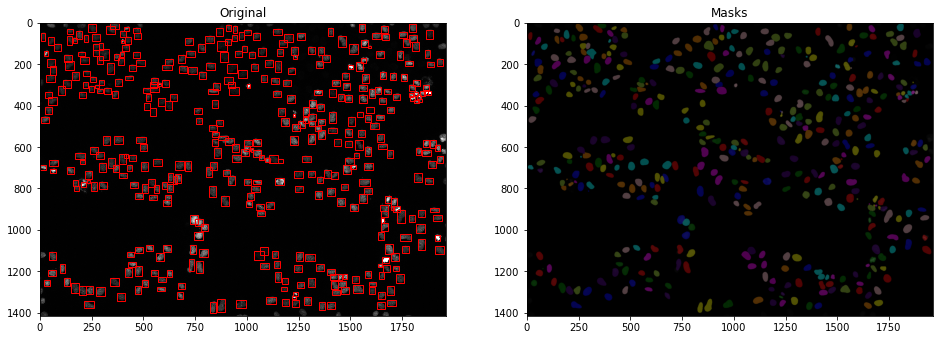

100% (1 of 1) |##########################| Elapsed Time: 0:00:03 Time:  0:00:03


In [16]:
# loop over every scene, timepoint and zplane incl progressbar for scenes
for s in progressbar.progressbar(range(md['SizeS']), redirect_stdout=True):
    for t in range(md['SizeT']):
        for z in range(md['SizeZ']):

            # get the current plane indicies and store them
            values = {'S': s, 'T': t, 'Z': z, 'C': chindex, 'Number': 0}

            if verbose:
                print('Analyzing S-T-Z-C: ', s, t, z, chindex)
            
            # read out a single 2D image planed using AICSImageIO
            image2d = img.get_image_data("YX", S=s, T=t, Z=z, C=chindex)

            # use the cellpose package to segemnt the nuclei
            if use_method == 'cellpose':
                # get the mask for the current image
                mask = sgt.segment_nuclei_cellpose(image2d, model,
                                                   rescale=None,
                                                   channels=channels,
                                                   diameter=diameter)
            
            # use scikit-image tools to segment the nuclei
            if use_method == 'scikit':
                mask = sgt.segment_threshold(image2d,
                                             filtermethod=filtermethod,
                                             filtersize=filtersize,
                                             threshold=threshold,
                                             split_ws=use_ws,
                                             min_distance=min_distance,
                                             ws_method=ws_method,
                                             radius=radius_dilation)
            
            # use the trained U-Net from ZEN blue 3.2 using TensorFlow 2 to segment the nuclei
            if use_method == 'zentf':

                # check if tiling is required if image2d is "too big" for the network
                if image2d.shape[0] > tile_height or image2d.shape[1] > tile_width:
                    binary = sgt.segment_zentf_tiling(image2d, model,
                                                      tilesize=tile_height,
                                                      classlabel=classlabel_zenunet,
                                                      overlap_factor=overlapfactor)

                # directly segment image if the size fits exactly
                elif image2d.shape[0] == tile_height and image2d.shape[1] == tile_width:
                    binary = sgt.segment_zentf(image2d, model,
                                               classlabel=classlabel_zenunet)

                # use padding if the image size is "too small" for the network
                elif image2d.shape[0] < tile_height or image2d.shape[1] < tile_width:

                    # do padding
                    image2d_padded, pad = sgt.add_padding(image2d,
                                                          input_height=tile_height,
                                                          input_width=tile_width)

                    # run prediction on padded image
                    binary_padded = sgt.segment_zentf(image2d_padded, model,
                                                      classlabel=classlabel_zenunet)

                    # remove padding from result
                    binary = binary_padded[pad[0]:tile_height - pad[1], pad[2]:tile_width - pad[3]]

                # apply watershed when specified
                if use_ws:
                    if ws_method == 'ws':
                        mask = sgt.apply_watershed(binary,
                                                   min_distance=min_distance)
                    if ws_method == 'ws_adv':
                        mask = sgt.apply_watershed_adv(image2d, binary,
                                                       min_distance=min_distance,
                                                       radius=radius_dilation)
                if not use_ws:
                    # label the objects
                    mask, num_features = ndimage.label(binary)
                    mask = mask.astype(np.int)
                    
            if use_method == 'stardist2d':

                mask = sgt.segment_nuclei_stardist(image2d, sdmodel,
                                                   prob_thresh=stardist_prob_thresh,
                                                   overlap_thresh=stardist_overlap_thresh,
                                                   norm=stardist_norm,
                                                   norm_pmin=stardist_norm_pmin,
                                                   norm_pmax=stardist_norm_pmax,
                                                   norm_clip=stardist_norm_clip)

            # clear the border by removing "touching" objects
            mask = segmentation.clear_border(mask)
            
            # define region properties to be measured
            to_measure = ('label',
                          'area',
                          'centroid',
                          'max_intensity',
                          'mean_intensity',
                          'min_intensity',
                          'bbox')

            # measure the specified parameters store in dataframe
            props = pd.DataFrame(
                measure.regionprops_table(
                    mask,
                    intensity_image=image2d,
                    properties=to_measure
                )
            ).set_index('label')

            # filter objects by size
            props = props[(props['area'] >= minsize) & (props['area'] <= maxsize)]

            # add well information for CZI metadata
            props['WellId'] = md['Well_ArrayNames'][s]
            props['Well_ColId'] = md['Well_ColId'][s]
            props['Well_RowId'] = md['Well_RowId'][s]

            # add plane indices
            props['S'] = s
            props['T'] = t
            props['Z'] = z
            props['C'] = chindex

            # count the number of objects
            values['Number'] = props.shape[0]
            # values['Number'] = len(regions) - 1
            if verbose:
                print('Well:', props['WellId'].iloc[0], 'Objects: ', values['Number'])

            # update dataframe containing the number of objects
            objects = objects.append(pd.DataFrame(values, index=[0]), ignore_index=True)
            results = results.append(props, ignore_index=True)

            image_counter += 1
            # optional display of results
            if image_counter - 1 in show_image:
                print('Well:', props['WellId'].iloc[0],
                      'Index S-T-Z-C:', s, t, z, chindex,
                      'Objects:', values['Number'])
                
                ax = sgt.plot_results(image2d, mask, props, add_bbox=True)

# reorder dataframe with single objects
new_order = list(results.columns[-7:]) + list(results.columns[:-7])
results = results.reindex(columns=new_order)

In [ ]:
# display objects for every analyzed scene
display(HTML(objects.to_html()))